<a href="https://colab.research.google.com/github/Lfickling/PaintingEmotion/blob/model-training/RawImageRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1083
Found 3483 files belonging to 8 classes.
Using 2787 files for training.
Found 3483 files belonging to 8 classes.
Using 696 files for validation.
['amusement', 'anger', 'awe', 'contentment', 'disgust', 'excitement', 'fear', 'sadness']


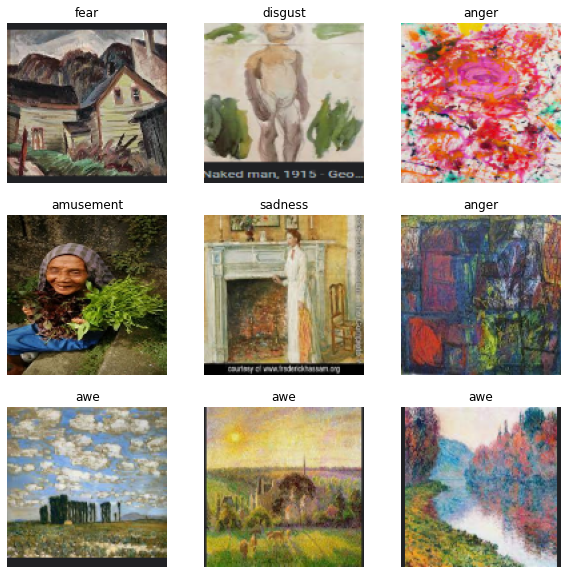

(10, 120, 120, 3)
(10,)
0.063558005 0.8202082
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout (

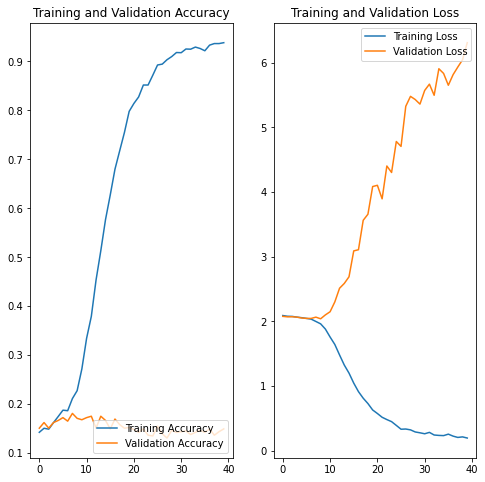

In [2]:
import os
import pathlib
import matplotlib.image
import numpy as np
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


!mkdir mydata
!cp -r /content/drive/MyDrive/SeniorExp/300andPhotoCombo /content/mydata

data_dir = pathlib.Path("./mydata/300andPhotoCombo/")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

batch_size = 10
img_height = 120
img_width = 120

checkpoint_path = "model-{epoch:02d}-acc_{accuracy:.4f}-valacc_{val_accuracy:.4f}.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1. / 255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Dropout(.55, seed=43),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.35, seed=567),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.35, seed=34),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.25, seed=45),
    layers.Dense(num_classes) # , activation='softmax'
])

model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

epochs = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = callbacks_list
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model_path = "model.h5"
model.save(model_path)



# New Section

This image most likely belongs to anger with a 26.66 percent confidence.


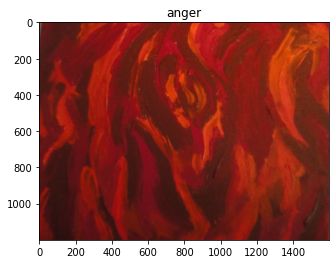

In [4]:
!cp -r /content/drive/MyDrive/SeniorExp/test.jpg /content/mydata
test_path = "./mydata/test.jpg"

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# load saved if needed
!cp -r /content/drive/MyDrive/SeniorExp/ModelCandidates/model-31-acc_0.7994-valacc_0.1940.h5 /content
model = tf.keras.models.load_model('model-31-acc_0.7994-valacc_0.1940.h5')

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img = matplotlib.image.imread(test_path)
plt.imshow(img)
plt.title(class_names[np.argmax(score)])
plt.show()


In [ ]:
# save model if good results
!cp -r /content/model_name /content/drive/MyDrive/SeniorExp/ModelCandidates